# TP 2 - algoritmos de ensambles 

## Cargar librerias


In [1]:
import datetime
import IPython
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import sweetviz as sv
import time
from numpy import mean, std
from urllib.parse import urlparse

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [3]:
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import randint as sp_randint

from sklearn.calibration import calibration_curve
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
)
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    roc_curve,
    auc,
    make_scorer,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score, LeaveOneGroupOut

In [4]:
# # Observación: Descomentar en caso de que quieran versionar los modelos y la búsqueda de hiperparámetros.
# import mlflow
# import mlflow.sklearn
# from mlflow.tracking import MlflowClient

In [5]:
PARAM_RANDOM_STATE = 42

## Cargar dataset

In [6]:
df_original = pd.read_csv("01.df.procesado.csv")
# df_original = pd.read_csv("https://raw.githubusercontent.com/blukitas/AA-2021/main/TPs/02.TP/01.df.procesado.csv")
df_original.shape

(2452, 99)

In [7]:
df_original.head()

,Unnamed: 0,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,start,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,./audios/ravdess/Actor_23/03-01-07-02-02-01-23...,3,1,7,2,2,1,23,0 days 00:00:00,...,0.075190,0.014015,0.022255,2.150538,1.089918,0.2825,0.126763,0.4900,0.397291,-36.658245
1,1,./audios/ravdess/Actor_23/03-02-03-02-02-01-23...,3,2,3,2,2,1,23,0 days 00:00:00,...,0.020998,0.009869,0.018871,1.492537,0.646552,0.8200,0.277248,0.5275,0.438770,-29.391884
2,2,./audios/ravdess/Actor_23/03-01-04-01-02-01-23...,3,1,4,1,2,1,23,0 days 00:00:00,...,0.047365,0.011048,0.011381,2.247191,0.569801,0.5900,0.160000,0.7600,0.296985,-43.332924
3,3,./audios/ravdess/Actor_23/03-02-04-02-02-01-23...,3,2,4,2,2,1,23,0 days 00:00:00,...,0.041743,0.012340,0.007390,1.394422,0.603622,0.9300,0.885701,0.5275,0.420260,-37.549572
4,4,./audios/ravdess/Actor_23/03-01-02-02-02-02-23...,3,1,2,2,2,2,23,0 days 00:00:00,...,0.053580,0.011590,0.005245,1.535088,0.886918,0.3875,0.206079,0.5740,0.424999,-43.261425


In [8]:
num_columns = [col for col in df_original.columns if df_original[col].dtype != "object"]
num_columns

['Unnamed: 0',
 'modality',
 'vocal_channel',
 'emotion',
 'emotional_intensity',
 'statement',
 'repetition',
 'actor',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1

In [9]:
drop_columns = [
    "file_path",
    "Unnamed: 0",
    "modality",
    "vocal_channel",
#     "emotion",
    "emotional_intensity",
    "statement",
    "repetition",
    "actor",
]
num_columns = [x for x in num_columns if x not in drop_columns]
num_columns

['emotion',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNor

In [10]:
df_proc = df_original[num_columns] #.head(10000)

## Split del dataset

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_proc.loc[:, df_proc.columns != "emotion"],
    df_proc["emotion"],
    stratify=df_proc["emotion"],
    random_state=PARAM_RANDOM_STATE,
)

## Groups

In [12]:
# groups = (X_train.actor // 2) + (X_train.actor % 2)
logo = LeaveOneGroupOut()
# logo.get_n_splits(X_train, y_train, groups)

In [13]:
groups = (df_original.actor // 2) + (df_original.actor % 2)

In [14]:
# sorted(groups)
sorted(groups.unique())
groups.value_counts()

11    208
7     208
5     208
3     208
1     208
12    208
10    208
8     208
6     208
4     208
2     208
9     164
Name: actor, dtype: int64

<AxesSubplot:>

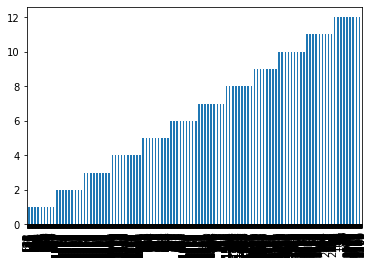

In [15]:
groups.sort_values().plot(kind="bar")

In [16]:
X_train = df_proc.loc[groups <= 10, df_proc.columns != "emotion"]
X_val = df_proc.loc[groups == 11, df_proc.columns != "emotion"]
X_train_val = df_proc.loc[groups <= 11, df_proc.columns != "emotion"]
X_test = df_proc.loc[groups == 12, df_proc.columns != "emotion"]

y_train = df_proc.loc[groups <= 10, "emotion"]
y_val = df_proc.loc[groups == 11, "emotion"]
y_train_val = df_proc.loc[groups <= 11, "emotion"]
y_test = df_proc.loc[groups == 12, "emotion"]

group_train = [x for x in groups if x <= 10]
group_val = [x for x in groups if x == 11]
group_train_val = [x for x in groups if x <= 11]
group_test = [x for x in groups if x == 12]

In [17]:
X_test

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,31.162280,0.103659,28.436132,31.203695,34.530006,6.093874,71.695320,42.723774,66.826570,39.508957,...,0.075190,0.014015,0.022255,2.150538,1.089918,0.282500,0.126763,0.490000,0.397291,-36.658245
1,32.832066,0.058510,31.873330,32.315525,34.425636,2.552307,74.677790,91.683740,26.730692,17.436796,...,0.020998,0.009869,0.018871,1.492537,0.646552,0.820000,0.277248,0.527500,0.438770,-29.391884
2,27.816698,0.067164,26.149890,27.284214,29.173655,3.023764,62.032460,63.740650,15.968684,9.053174,...,0.047365,0.011048,0.011381,2.247191,0.569801,0.590000,0.160000,0.760000,0.296985,-43.332924
3,32.421530,0.047639,31.190117,31.982471,34.491623,3.301506,40.428272,57.734535,13.244412,10.956038,...,0.041743,0.012340,0.007390,1.394422,0.603622,0.930000,0.885701,0.527500,0.420260,-37.549572
4,27.446953,0.111269,24.586010,26.893717,29.436794,4.850784,44.066093,39.952390,21.916230,7.514049,...,0.053580,0.011590,0.005245,1.535088,0.886918,0.387500,0.206079,0.574000,0.424999,-43.261425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,33.384823,0.129291,29.832968,34.702780,36.774480,6.941511,182.749420,97.858444,94.744020,83.644226,...,0.120215,0.007377,0.020331,1.970443,1.246883,0.304000,0.177831,0.474000,0.398979,-38.670864
2240,44.803856,0.036632,43.755340,44.315247,46.523070,2.767731,19.188236,3.504527,7.420811,6.073164,...,0.124252,0.006430,0.009222,1.829268,1.437372,0.334286,0.253932,0.338571,0.450315,-41.181730
2241,45.137970,0.160381,38.204502,43.318493,54.491745,16.287243,297.005070,482.484800,80.743450,36.427788,...,0.101797,0.006154,0.036091,2.020202,1.278773,0.284000,0.136029,0.396667,0.468496,-35.436405
2242,36.912320,0.074441,34.913330,36.732590,39.113068,4.199738,43.395910,41.328815,120.333530,145.930900,...,0.110965,0.011310,0.010739,2.313625,1.562500,0.243333,0.238723,0.321429,0.451519,-44.980280


# TODO: Seguir desde acá usando estos train-val-test para todos 

## Métrica

In [18]:
scorer_f1 = make_scorer(fbeta_score, beta=1,  average='macro') 

In [24]:
n_iter_search = 1000

## Desarrollo de modelos de ensamble

B) Elegir un modelo de ensamble visto durante las clases y entrenarlo para predecir emociones dividiendo el dataset de las siguientes maneras:
    i) 12-fold cross validation armando los folds de forma aleatoria.
    ii) Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos. Se recomienda utilizar la función de sklearn LeaveOneGroupOut

Reportar los resultados obtenidos y realizar un análisis de los mismos, teniendo en cuenta las características del dataset utilizado.

### Métricas

f1

Si no está desbalanceado accuracy puede ser bien. F1 es un poco más robusta, pensando en que tiene en cuenta recall y precision.

No hay elementos que inclinen la balanza.

<BarContainer object of 8 artists>

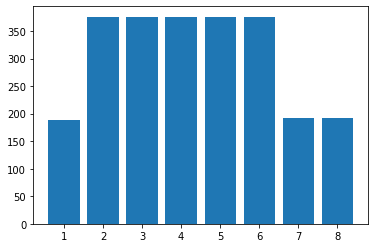

In [19]:
plt.bar(
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count(),
)

#### Setup mlflow
Mlflow es una herramienta para versionado de modelos. Permite registrar paramétros, métricas y guardar los modelos entrenados asociados a una iteración.

En caso de no ser necesario comentar estas lineas.

In [20]:
# # now = datetime.datetime.now()
# mlflow.set_tracking_uri("http://mlflow_server:5000")
# tracking_uri = mlflow.get_tracking_uri()
# print("Current tracking uri: {}".format(tracking_uri))

In [21]:
# # No hace falta el create, el set lo crea si no existe
# experiment = mlflow.set_experiment(
#     "AA.TP2.Bagging.{0}".format(now.strftime("%Y-%m-%d"))
# )

### Método elegido -> Bagging

Bagging con n árboles


Combinan strong learners, los cuales tienen varianza alta, para reducir su varianza. El bagging consiste en utilizar distintos subsets de los datos de entrenamiento para entrenar cada learner. Los subsets se generan tomando muestras con reemplazo. Si no se hace reemplazo se denomina **pasting**, y si en lugar de tomar subsets sobre los datos, los tomamos sobre los atributos, se denomina **random subspaces**. La combinación de bagging y random subspaces se denomina **random patches**.

https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting

Scikit Learn cuenta un tipo de objetos llamados meta-estimadores para representar a los ensambles. Este nombre se debe a que estos meta-estimadores necesitan definir estimadores base que van a ser justamente los modelos que se ajusten en cada uno de los pasos de bootstrapping. Como modelos/estimadores base podemos instanciar cualquier estimador de sklearn. Para el caso de Bagging, el meta-estimador para clasificación es:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Este objeto tiene como principal parámetro a base_estimator en el cual instanciaremos un modelo. Veamos un pequeño ejemplo:

**tbd** Acomodarlo a los árboles que usamos

In [22]:
# Version 0 del árbol

# kfold = KFold(n_splits = 12,
#                        random_state = PARAM_RANDOM_STATE, shuffle=True)
  
# # initialize the base classifier
# # TBD: Inicializar con el mejor árbol
# #      ¿Se puede inicializar con n arboles?
# # TBD: Hacer un par y compararlos? Tiene sentido?
# base_cls = DecisionTreeClassifier()
  
# # no. of base classifier
# num_trees = 1000
  
# # bagging classifier
# model = BaggingClassifier(base_estimator = base_cls,
#                           n_estimators = num_trees,
#                           random_state = PARAM_RANDOM_STATE)
  
# # max_samples en float nos dice que porcentaje del training set queremos remuestrear
# # max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos
# results = cross_val_score(model, X_train, y_train, cv = kfold)

# # fit
# model.fit(X_train, y_train)

In [23]:
start = time.time()

kfold = StratifiedKFold(n_splits=12, random_state=PARAM_RANDOM_STATE, shuffle=True)
scorer_fn = make_scorer(
    f1_score, average="weighted"
)  # seteamos una metrica apropiada al problema multiclase

base_cls = DecisionTreeClassifier(class_weight="balanced")

# no. of base classifier
num_trees = 1000

# bagging classifier
model = BaggingClassifier(
    base_estimator=base_cls,
    n_estimators=num_trees,
    random_state=PARAM_RANDOM_STATE,
    # shuffle=True,
    n_jobs=10,
    verbose=True,
)

results_f1 = cross_val_score(
    estimator=model, X=X_train, y=y_train, cv=kfold, n_jobs=10, scoring=scorer_fn
)
model.fit(X_train, y_train)

end = time.time()
print(f"Tiempo: { round(end - start, 2) } segundos")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   22.6s remaining:  1.5min


Tiempo: 272.13 segundos


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   23.7s finished


In [24]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(model, open('03.02.Bagging_stratified_balanced.pkl', 'wb'))

## Comparación de modelos

C) Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

1. Train/Test
2. Métrica
3. Busqueda hiperparámetros (Cuáles son los hiperparametros? Cual el espacio de búsqueda acotado?)
    * Random forest
    * Adaboost
4. Comparación de modelos
    * Matriz de confusión
5. Comprar ambos modelos
    * Cantados
    * Hablados

### Métrica

f1

### Random Forests

Random Forest es una implementación de un algoritmo de *Bagging* que propone como estimadores base a **n_estimators** árboles de decisión. Cada árbol verá un subset distinto de los datos de entrenamiento (bagging, llamado **bootstrap** en los parámetros de sklearn). A su vez, para elegir el mejor split en cada nivel, se tienen en cuenta solo **max_features** atributos, seleccionados al azar. Estas 2 técnicas combinadas llevan a obtener árboles que sean distintos entre si y estén decorrelacionados, lo cual es bueno ya que si un árbol comete errores, probablemente otros no lo cometerán y se compensarán. Cuanto más independientes sean los árboles entre si más reduciremos la varianza.

random forest pelado

In [25]:
rf = RandomForestClassifier(n_estimators=1000, random_state=PARAM_RANDOM_STATE)
rf.fit(X_train, y_train)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_val, y_val)))

Accuracy training : 1.000
Accuracy test: 0.548


In [26]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(rf, open('03.03.Random_forest.pkl', 'wb'))

In [27]:
y_train.value_counts()

6    312
5    312
4    312
3    312
2    312
8    160
7    160
1    156
Name: emotion, dtype: int64

In [28]:
train_pred = rf.predict(X_train)
pd.Series(train_pred).value_counts()

6    312
5    312
4    312
3    312
2    312
8    160
7    160
1    156
dtype: int64

In [29]:
n_estimators = range(10, 1500, 10)
train_results = []
test_results = []
for estimator in n_estimators:
    print(f"estimator: {estimator}")
    
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    aux = accuracy_score(y_train, train_pred)
    train_results.append(aux)

    y_pred = rf.predict(X_val)
    aux = accuracy_score(y_pred, y_val)
    test_results.append(aux)

estimator: 10
estimator: 20
estimator: 30
estimator: 40
estimator: 50
estimator: 60
estimator: 70
estimator: 80
estimator: 90
estimator: 100
estimator: 110
estimator: 120
estimator: 130
estimator: 140
estimator: 150
estimator: 160
estimator: 170
estimator: 180
estimator: 190
estimator: 200
estimator: 210
estimator: 220
estimator: 230
estimator: 240
estimator: 250
estimator: 260
estimator: 270
estimator: 280
estimator: 290
estimator: 300
estimator: 310
estimator: 320
estimator: 330
estimator: 340
estimator: 350
estimator: 360
estimator: 370
estimator: 380
estimator: 390
estimator: 400
estimator: 410
estimator: 420
estimator: 430
estimator: 440
estimator: 450
estimator: 460
estimator: 470
estimator: 480
estimator: 490
estimator: 500
estimator: 510
estimator: 520
estimator: 530
estimator: 540
estimator: 550
estimator: 560
estimator: 570
estimator: 580
estimator: 590
estimator: 600
estimator: 610
estimator: 620
estimator: 630
estimator: 640
estimator: 650
estimator: 660
estimator: 670
esti

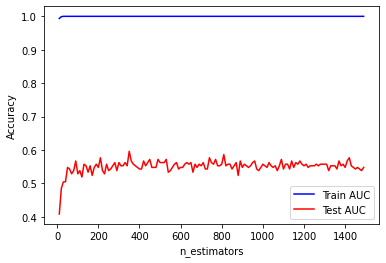

In [30]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  
line1 = ax.plot(n_estimators, train_results, "b", label="Train AUC")
line2= ax.plot(n_estimators, test_results, "r", label="Test AUC")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

fig.savefig(
    "03.05.Evolucion.n_estimators.png", bbox_inches='tight'
)

In [31]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    print(f"max_depth: {max_depth}")

    rf = RandomForestClassifier(
        max_depth=max_depth, n_jobs=-1, random_state=PARAM_RANDOM_STATE
    )
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    aux = accuracy_score(y_train, train_pred)
    train_results.append(aux)

    y_pred = rf.predict(X_val)
    aux = accuracy_score(y_pred, y_val)
    test_results.append(aux)

max_depth: 1.0
max_depth: 2.0
max_depth: 3.0
max_depth: 4.0
max_depth: 5.0
max_depth: 6.0
max_depth: 7.0
max_depth: 8.0
max_depth: 9.0
max_depth: 10.0
max_depth: 11.0
max_depth: 12.0
max_depth: 13.0
max_depth: 14.0
max_depth: 15.0
max_depth: 16.0
max_depth: 17.0
max_depth: 18.0
max_depth: 19.0
max_depth: 20.0
max_depth: 21.0
max_depth: 22.0
max_depth: 23.0
max_depth: 24.0
max_depth: 25.0
max_depth: 26.0
max_depth: 27.0
max_depth: 28.0
max_depth: 29.0
max_depth: 30.0
max_depth: 31.0
max_depth: 32.0


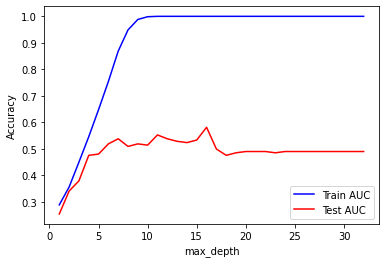

In [32]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  
line1 = ax.plot(max_depths, train_results, "b", label="Train AUC")
line2 = ax.plot(max_depths, test_results, "r", label="Test AUC")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()
plt.show()

fig.savefig("03.05.Evolucion.max_depth.png", bbox_inches="tight")

In [33]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    print(f"max_feature: {max_feature}")
    rf = RandomForestClassifier(max_features=max_feature, n_jobs=-1, random_state=PARAM_RANDOM_STATE)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    aux = accuracy_score(y_train, train_pred)
    train_results.append(aux)

    y_pred = rf.predict(X_val)
    aux = accuracy_score(y_pred, y_val)
    test_results.append(aux)

max_feature: 1
max_feature: 2
max_feature: 3
max_feature: 4
max_feature: 5
max_feature: 6
max_feature: 7
max_feature: 8
max_feature: 9
max_feature: 10
max_feature: 11
max_feature: 12
max_feature: 13
max_feature: 14
max_feature: 15
max_feature: 16
max_feature: 17
max_feature: 18
max_feature: 19
max_feature: 20
max_feature: 21
max_feature: 22
max_feature: 23
max_feature: 24
max_feature: 25
max_feature: 26
max_feature: 27
max_feature: 28
max_feature: 29
max_feature: 30
max_feature: 31
max_feature: 32
max_feature: 33
max_feature: 34
max_feature: 35
max_feature: 36
max_feature: 37
max_feature: 38
max_feature: 39
max_feature: 40
max_feature: 41
max_feature: 42
max_feature: 43
max_feature: 44
max_feature: 45
max_feature: 46
max_feature: 47
max_feature: 48
max_feature: 49
max_feature: 50
max_feature: 51
max_feature: 52
max_feature: 53
max_feature: 54
max_feature: 55
max_feature: 56
max_feature: 57
max_feature: 58
max_feature: 59
max_feature: 60
max_feature: 61
max_feature: 62
max_feature: 63
m

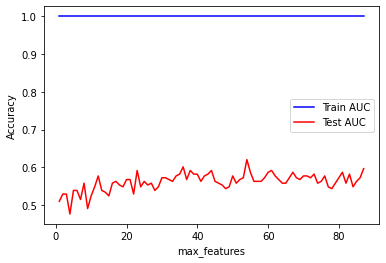

In [34]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  
line1 = ax.plot(max_features, train_results, "b", label="Train AUC")
line2 = ax.plot(max_features, test_results, "r", label="Test AUC")
plt.ylabel("Accuracy")
plt.xlabel("max_features")
plt.legend()
plt.show()

fig.savefig("03.05.Evolucion.max_features.png", bbox_inches="tight")

In [35]:
# now = datetime.datetime.now()
# mlflow.set_tracking_uri("http://mlflow_server:5000")
# tracking_uri = mlflow.get_tracking_uri()
# print("Current tracking uri: {}".format(tracking_uri))

# # No hace falta el create, el set lo crea si no existe
# experiment = mlflow.set_experiment(
#     "AA.TP2.RandomForest.{0}".format(now.strftime("%Y-%m-%d"))
# )

Busqueda de hiperparametros random forest 

In [36]:
start = time.time()
param_dist = {
    "n_estimators": range(200, 550, 10),
#     "max_depth": sp_randint(10, 25),
#     "max_feature": range(5, 20),
}
# "max_features": sp_randint(5, 30),
# "max_depth": [10]}
# "min_samples_leaf": sp_randint(2, 17),
# "criterion": ['entropy', 'gini']}

clf = RandomForestClassifier(random_state=PARAM_RANDOM_STATE)

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring=scorer_f1,
    cv=logo,
    n_jobs=10,
    verbose=10,
    random_state=PARAM_RANDOM_STATE,
)
random_search.fit(X_train, y_train, group_train)

end = time.time()

Fitting 10 folds for each of 35 candidates, totalling 350 fits


/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass groups=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [37]:
# Tiempo de búsqueda de hiperparámetros
print(f"Tiempo: { round(end - start, 2) } segundos")

Tiempo: 330.63 segundos


In [38]:
random_search

RandomizedSearchCV(cv=LeaveOneGroupOut(),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=1000, n_jobs=10,
                   param_distributions={'n_estimators': range(200, 550, 10)},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, beta=1, average=macro),
                   verbose=10)

In [39]:
pd.DataFrame(random_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,4.854025,0.512333,0.061730,0.018480,200,{'n_estimators': 200},0.496509,0.464139,0.496087,0.581124,0.355557,0.546429,0.580346,0.535088,0.400741,0.511713,0.496773,0.069632,27
1,5.237094,0.502824,0.063663,0.021311,210,{'n_estimators': 210},0.496648,0.481710,0.505180,0.582439,0.348431,0.548654,0.578239,0.535516,0.402102,0.507530,0.498645,0.070366,16
2,5.541854,0.607316,0.069621,0.025646,220,{'n_estimators': 220},0.497259,0.485733,0.490449,0.586108,0.362756,0.538733,0.559493,0.532729,0.399718,0.495398,0.494838,0.065173,34
3,5.798752,0.504203,0.075117,0.026016,230,{'n_estimators': 230},0.502542,0.478064,0.500682,0.606812,0.359437,0.532122,0.575201,0.523830,0.402822,0.498021,0.497953,0.069509,22
4,5.735247,0.332753,0.071546,0.018139,240,{'n_estimators': 240},0.490672,0.478715,0.480363,0.609478,0.355587,0.525770,0.569547,0.528583,0.397814,0.494254,0.493078,0.070767,35


In [40]:
# Visualizar las opciones que nos devolvió
aux = pd.DataFrame(random_search.cv_results_)

In [41]:
rf = random_search.best_estimator_
print(random_search.best_score_, random_search.best_params_)

0.5033892717811403 {'n_estimators': 360}


In [42]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 360,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [43]:
# Reporte de clasificación
best_model = random_search.best_estimator_
y_pred = rf.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.50      0.59        16
           2       0.56      0.78      0.65        32
           3       0.44      0.59      0.51        32
           4       0.50      0.31      0.38        32
           5       0.49      0.84      0.62        32
           6       1.00      0.44      0.61        32
           7       0.00      0.00      0.00        16
           8       0.91      0.62      0.74        16

    accuracy                           0.54       208
   macro avg       0.58      0.51      0.51       208
weighted avg       0.59      0.54      0.53       208



In [44]:
now = datetime.datetime.now()

In [45]:
aux.to_csv('03.04.AA.TP2.RandomForest.{0}.csv'.format(now.strftime("%Y-%m-%d")))

In [46]:
# # Explorar la columnas para registrarlas en mlflow
# params = [x for x in aux.columns if "param_" in x]
# print(params)
# score = [x for x in aux.columns if "score" in x]
# print(score)
# col_time = [x for x in aux.columns if "time" in x]
# print(time)

In [47]:
# # Registro y versionado de modelo en mlflow
# #   Comentar en caso de no estar utilizandolo

# start = time.time()
# for index, row in aux.iterrows():
#     with mlflow.start_run(experiment):
#         mlflow.log_param('Busqueda', 'RandomizedSearchCV')
#         for i in params:
#             # print('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_param(i, row[i])

#         for i in score:
#             # print('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])

#         for i in col_time:
#             # print('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])
# end = time.time()
# print(f"Tiempo: { end - start }")

In [48]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(clf, open('03.04.Random_forest_search.pkl', 'wb'))

In [49]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(rf, open('03.04.Random_forest.pkl', 'wb'))

In [50]:
# En caso de estar reejecutando => load model
# loaded_model = pickle.load(open('03.02.Bagging_balanced.pkl', 'rb'))
loaded_model = pickle.load(open('03.04.Random_forest.pkl', 'rb'))

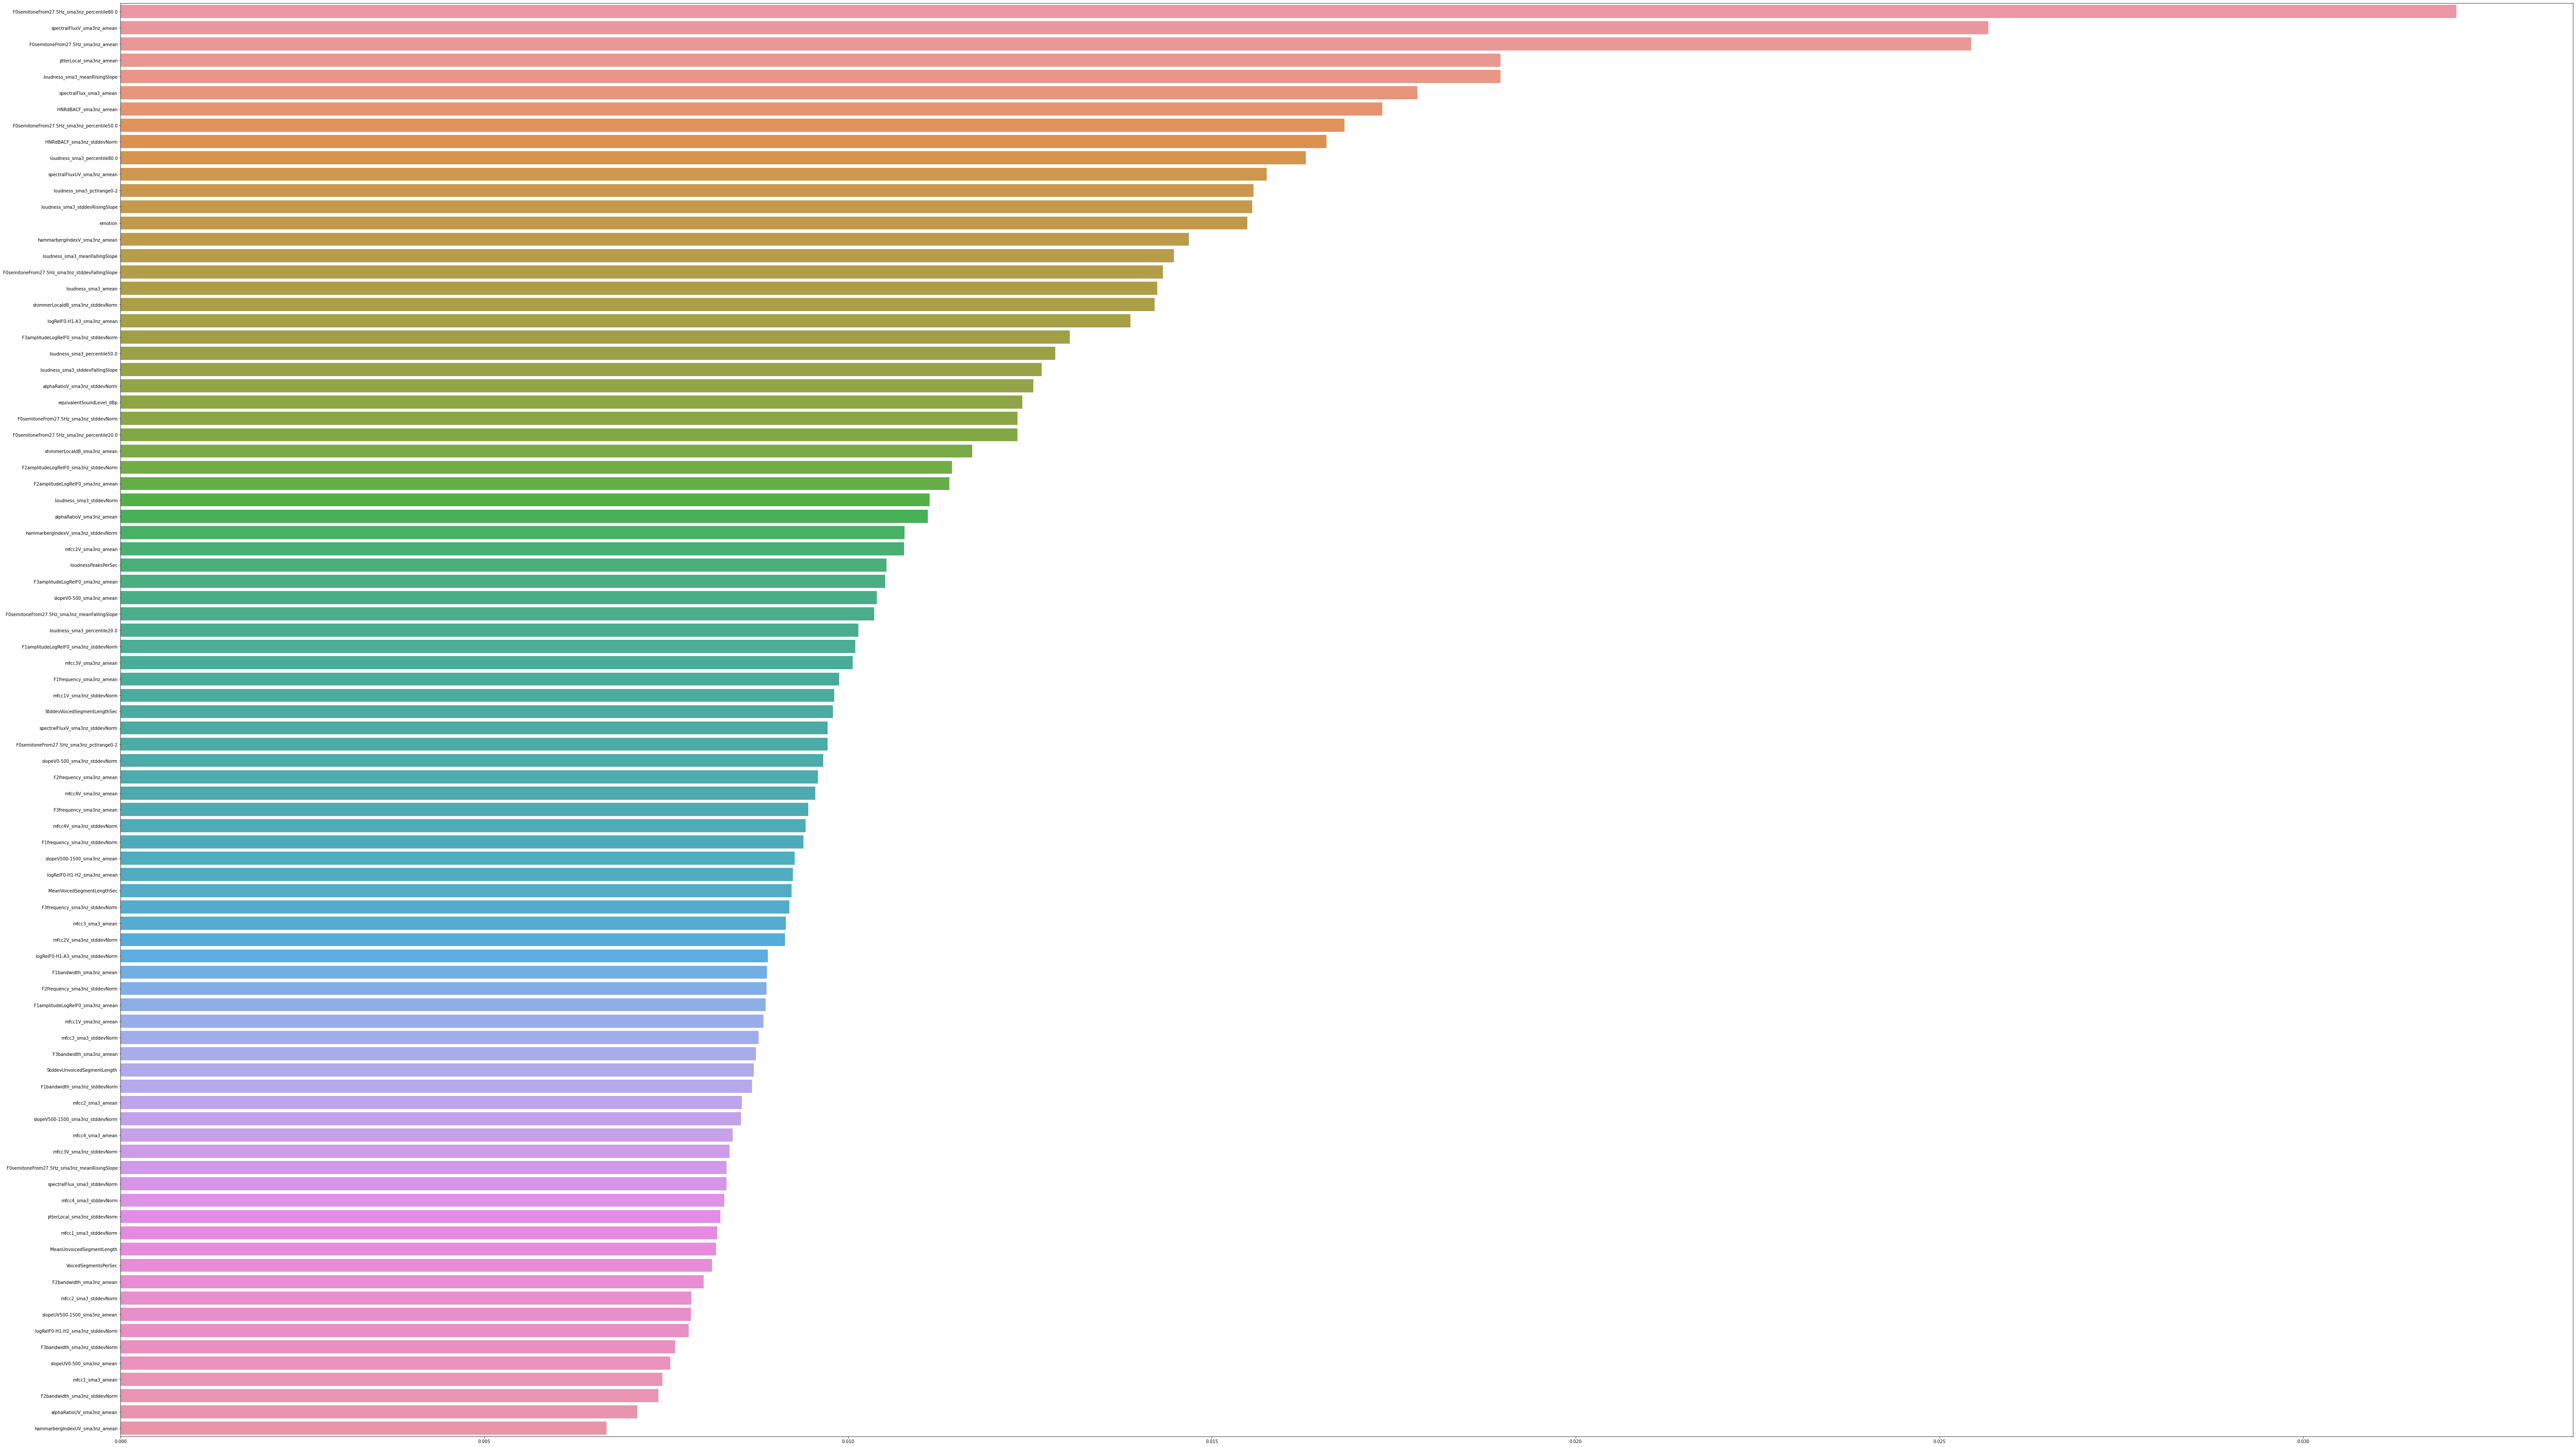

In [51]:
features = [x for i, x in enumerate(df_proc.columns) if i != 8]
feat_importances = loaded_model.feature_importances_

plt.figure(figsize=(100, 60))
graph_importance = sns.barplot(
    y=features,
    x=feat_importances,
    orient="h",
    order=reversed(np.array(features)[np.argsort(feat_importances)]),
)


graph_importance.figure.savefig(
    "03.04.Random_forest.feature_importante.png", bbox_inches='tight'
)

In [52]:
# df_proc.loc[:, df_proc.columns != "emotion"],
#     df_proc["emotion"],
    
importancia_predictores = pd.DataFrame(
    {"Predictor": df_proc.loc[:, df_proc.columns != "emotion"], "Importancia": loaded_model.feature_importances_}
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("Importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,Predictor,Importancia
5,"(F, 0, s, e, m, i, t, o, n, e, F, r, o, m, 2, ...",0.032106
66,"(s, p, e, c, t, r, a, l, F, l, u, x, V, _, s, ...",0.025672
1,"(F, 0, s, e, m, i, t, o, n, e, F, r, o, m, 2, ...",0.025441
30,"(j, i, t, t, e, r, L, o, c, a, l, _, s, m, a, ...",0.018968
16,"(l, o, u, d, n, e, s, s, _, s, m, a, 3, _, m, ...",0.018967
...,...,...
78,"(s, l, o, p, e, U, V, 0, -, 5, 0, 0, _, s, m, ...",0.007555
22,"(m, f, c, c, 1, _, s, m, a, 3, _, a, m, e, a, n)",0.007447
49,"(F, 2, b, a, n, d, w, i, d, t, h, _, s, m, a, ...",0.007392
76,"(a, l, p, h, a, R, a, t, i, o, U, V, _, s, m, ...",0.007099


In [53]:
y_pred_test = loaded_model.predict(X_val)
y_pred_train = loaded_model.predict(X_train)

In [54]:
# evaluación
print("Accuracy training : {:.3f}".format(loaded_model.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(loaded_model.score(X_val, y_val)))
print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_val, y_pred_test)))
print("Test recall: {}".format(recall_score(y_val, y_pred_test, average="weighted")))
print(
    "Test F1: {}".format(fbeta_score(y_val, y_pred_test, beta=1, average="weighted"))
)
print(
    "Test F2: {}".format(fbeta_score(y_val, y_pred_test, beta=2, average="weighted"))
)

Accuracy training : 1.000
Accuracy test: 0.543
Train acc: 1.0
Test acc: 0.5432692307692307
Test recall: 0.5432692307692307
Test F1: 0.5287207191762606
Test F2: 0.5302460631548015


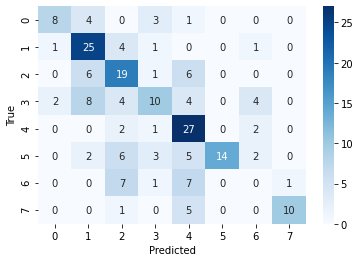

In [55]:
cm = confusion_matrix(y_val, y_pred_test)
matriz_n_aria = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")


matriz_n_aria .figure.savefig(
    "03.04.Random_forest.matriz.png", bbox_inches='tight'
)

### AdaBoost
En cada iteración construye un stump nuevo y le da más peso a las muestras que fueron clasificadas mal por el anterior stump. De esta manera, en cada iteración se intenta corregir los errores que cometió el anterior clasificador. Una vez armado el ensamble, cada stump tendrá asociado un peso en sus predicciones de acuerdo a qué tan bueno fue clasificando durante el entrenamiento. A continuación les dejamos un video explicativo del funcionamiento del algoritmo:

https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified

La implementación de AdaBoost de sklearn nos provee de un meta-estimador para Boosting, al cual le podemos pasar cualquier estimador (por defecto usa un arbol de profundidad 1, un stump):

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier

Paper original:
https://web.stanford.edu/~hastie/Papers/samme.pdf 


In [22]:
n_estimators = range(10, 2000, 25)
train_results = []
test_results = []

In [56]:

for estimator in n_estimators:
    #     rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    ad = AdaBoostClassifier(
        DecisionTreeClassifier(
            class_weight="balanced", max_features="auto", max_depth=3
        ),
        n_estimators=estimator,
        random_state=PARAM_RANDOM_STATE,
    )
    ad.fit(X_train, y_train)
    train_pred = ad.predict(X_train)
    aux_train = accuracy_score(y_train, train_pred)
    train_results.append(aux_train)

    y_pred = ad.predict(X_val)
    aux_pred = accuracy_score(y_pred, y_val)
    test_results.append(aux_pred)

    print(
        f"estimator: {estimator}, train_accuracy: {aux_train}, test_accuracy: {aux_pred}"
    )

estimator: 10, train_accuracy: 0.4582514734774067, test_accuracy: 0.4375
estimator: 35, train_accuracy: 0.4715127701375246, test_accuracy: 0.34134615384615385
estimator: 60, train_accuracy: 0.5171905697445972, test_accuracy: 0.41346153846153844
estimator: 85, train_accuracy: 0.5648330058939096, test_accuracy: 0.42788461538461536
estimator: 110, train_accuracy: 0.5957760314341847, test_accuracy: 0.40865384615384615
estimator: 135, train_accuracy: 0.5962671905697446, test_accuracy: 0.4326923076923077
estimator: 160, train_accuracy: 0.6237721021611002, test_accuracy: 0.41346153846153844
estimator: 185, train_accuracy: 0.6350687622789783, test_accuracy: 0.41346153846153844
estimator: 210, train_accuracy: 0.6434184675834971, test_accuracy: 0.4182692307692308
estimator: 235, train_accuracy: 0.6728880157170923, test_accuracy: 0.39903846153846156
estimator: 260, train_accuracy: 0.6925343811394892, test_accuracy: 0.3894230769230769
estimator: 285, train_accuracy: 0.7141453831041258, test_accura

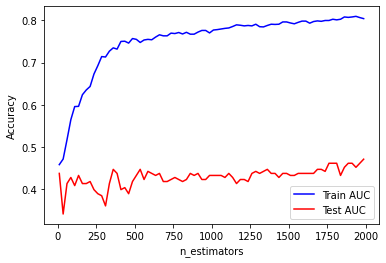

In [57]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  
line1 = ax.plot(n_estimators, train_results, "b", label="Train AUC")
line2 = ax.plot(n_estimators, test_results, "r", label="Test AUC")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

fig.savefig("03.05.AdaBoost.n_estimators.png", bbox_inches="tight")

In [58]:
learning_rates = np.arange(0.001, 3, 0.001)
train_results = []
test_results = []
for learning_rate in learning_rates:
    print(f"learning_rate: {learning_rate}")
    ad = AdaBoostClassifier(
        DecisionTreeClassifier(
            class_weight="balanced", max_features="auto", max_depth=3
        ),
        learning_rate=learning_rate, 
        random_state=PARAM_RANDOM_STATE
    )
    ad.fit(X_train, y_train)
    train_pred = ad.predict(X_train)
    aux = accuracy_score(y_train, train_pred)
    train_results.append(aux)

    y_pred = ad.predict(X_val)
    aux = accuracy_score(y_pred, y_val)
    test_results.append(aux)

learning_rate: 0.001
learning_rate: 0.002
learning_rate: 0.003
learning_rate: 0.004
learning_rate: 0.005
learning_rate: 0.006
learning_rate: 0.007
learning_rate: 0.008
learning_rate: 0.009000000000000001
learning_rate: 0.010000000000000002
learning_rate: 0.011
learning_rate: 0.012
learning_rate: 0.013000000000000001
learning_rate: 0.014000000000000002
learning_rate: 0.015
learning_rate: 0.016
learning_rate: 0.017
learning_rate: 0.018000000000000002
learning_rate: 0.019000000000000003
learning_rate: 0.02
learning_rate: 0.021
learning_rate: 0.022000000000000002
learning_rate: 0.023
learning_rate: 0.024
learning_rate: 0.025
learning_rate: 0.026000000000000002
learning_rate: 0.027000000000000003
learning_rate: 0.028
learning_rate: 0.029
learning_rate: 0.030000000000000002
learning_rate: 0.031
learning_rate: 0.032
learning_rate: 0.033
learning_rate: 0.034
learning_rate: 0.035
learning_rate: 0.036000000000000004
learning_rate: 0.037000000000000005
learning_rate: 0.038
learning_rate: 0.039
le

learning_rate: 0.34800000000000003
learning_rate: 0.34900000000000003
learning_rate: 0.35000000000000003
learning_rate: 0.35100000000000003
learning_rate: 0.35200000000000004
learning_rate: 0.353
learning_rate: 0.354
learning_rate: 0.355
learning_rate: 0.356
learning_rate: 0.357
learning_rate: 0.358
learning_rate: 0.359
learning_rate: 0.36
learning_rate: 0.361
learning_rate: 0.362
learning_rate: 0.363
learning_rate: 0.364
learning_rate: 0.365
learning_rate: 0.366
learning_rate: 0.367
learning_rate: 0.368
learning_rate: 0.369
learning_rate: 0.37
learning_rate: 0.371
learning_rate: 0.372
learning_rate: 0.373
learning_rate: 0.374
learning_rate: 0.375
learning_rate: 0.376
learning_rate: 0.377
learning_rate: 0.378
learning_rate: 0.379
learning_rate: 0.38
learning_rate: 0.381
learning_rate: 0.382
learning_rate: 0.383
learning_rate: 0.384
learning_rate: 0.385
learning_rate: 0.386
learning_rate: 0.387
learning_rate: 0.388
learning_rate: 0.389
learning_rate: 0.39
learning_rate: 0.391
learning_r

learning_rate: 0.7030000000000001
learning_rate: 0.7040000000000001
learning_rate: 0.705
learning_rate: 0.706
learning_rate: 0.707
learning_rate: 0.708
learning_rate: 0.709
learning_rate: 0.71
learning_rate: 0.711
learning_rate: 0.712
learning_rate: 0.713
learning_rate: 0.714
learning_rate: 0.715
learning_rate: 0.716
learning_rate: 0.717
learning_rate: 0.718
learning_rate: 0.719
learning_rate: 0.72
learning_rate: 0.721
learning_rate: 0.722
learning_rate: 0.723
learning_rate: 0.724
learning_rate: 0.725
learning_rate: 0.726
learning_rate: 0.727
learning_rate: 0.728
learning_rate: 0.729
learning_rate: 0.73
learning_rate: 0.731
learning_rate: 0.732
learning_rate: 0.733
learning_rate: 0.734
learning_rate: 0.735
learning_rate: 0.736
learning_rate: 0.737
learning_rate: 0.738
learning_rate: 0.739
learning_rate: 0.74
learning_rate: 0.741
learning_rate: 0.742
learning_rate: 0.743
learning_rate: 0.744
learning_rate: 0.745
learning_rate: 0.746
learning_rate: 0.747
learning_rate: 0.748
learning_rat

learning_rate: 1.057
learning_rate: 1.0579999999999998
learning_rate: 1.059
learning_rate: 1.0599999999999998
learning_rate: 1.061
learning_rate: 1.0619999999999998
learning_rate: 1.063
learning_rate: 1.0639999999999998
learning_rate: 1.065
learning_rate: 1.0659999999999998
learning_rate: 1.067
learning_rate: 1.0679999999999998
learning_rate: 1.069
learning_rate: 1.0699999999999998
learning_rate: 1.071
learning_rate: 1.0719999999999998
learning_rate: 1.073
learning_rate: 1.0739999999999998
learning_rate: 1.075
learning_rate: 1.0759999999999998
learning_rate: 1.077
learning_rate: 1.0779999999999998
learning_rate: 1.079
learning_rate: 1.0799999999999998
learning_rate: 1.081
learning_rate: 1.0819999999999999
learning_rate: 1.083
learning_rate: 1.0839999999999999
learning_rate: 1.085
learning_rate: 1.0859999999999999
learning_rate: 1.087
learning_rate: 1.0879999999999999
learning_rate: 1.089
learning_rate: 1.0899999999999999
learning_rate: 1.091
learning_rate: 1.0919999999999999
learning_r

learning_rate: 1.3699999999999999
learning_rate: 1.371
learning_rate: 1.3719999999999999
learning_rate: 1.373
learning_rate: 1.3739999999999999
learning_rate: 1.375
learning_rate: 1.376
learning_rate: 1.377
learning_rate: 1.378
learning_rate: 1.379
learning_rate: 1.38
learning_rate: 1.381
learning_rate: 1.382
learning_rate: 1.383
learning_rate: 1.384
learning_rate: 1.385
learning_rate: 1.386
learning_rate: 1.387
learning_rate: 1.388
learning_rate: 1.389
learning_rate: 1.39
learning_rate: 1.391
learning_rate: 1.392
learning_rate: 1.393
learning_rate: 1.394
learning_rate: 1.395
learning_rate: 1.396
learning_rate: 1.397
learning_rate: 1.398
learning_rate: 1.399
learning_rate: 1.4
learning_rate: 1.401
learning_rate: 1.402
learning_rate: 1.403
learning_rate: 1.404
learning_rate: 1.405
learning_rate: 1.406
learning_rate: 1.407
learning_rate: 1.408
learning_rate: 1.4089999999999998
learning_rate: 1.41
learning_rate: 1.4109999999999998
learning_rate: 1.412
learning_rate: 1.4129999999999998
lea

learning_rate: 1.696
learning_rate: 1.6969999999999998
learning_rate: 1.698
learning_rate: 1.6989999999999998
learning_rate: 1.7
learning_rate: 1.7009999999999998
learning_rate: 1.702
learning_rate: 1.7029999999999998
learning_rate: 1.704
learning_rate: 1.7049999999999998
learning_rate: 1.706
learning_rate: 1.7069999999999999
learning_rate: 1.708
learning_rate: 1.7089999999999999
learning_rate: 1.71
learning_rate: 1.7109999999999999
learning_rate: 1.712
learning_rate: 1.7129999999999999
learning_rate: 1.714
learning_rate: 1.7149999999999999
learning_rate: 1.716
learning_rate: 1.7169999999999999
learning_rate: 1.718
learning_rate: 1.7189999999999999
learning_rate: 1.72
learning_rate: 1.7209999999999999
learning_rate: 1.722
learning_rate: 1.7229999999999999
learning_rate: 1.724
learning_rate: 1.7249999999999999
learning_rate: 1.726
learning_rate: 1.7269999999999999
learning_rate: 1.728
learning_rate: 1.7289999999999999
learning_rate: 1.73
learning_rate: 1.7309999999999999
learning_rate: 

learning_rate: 2.021
learning_rate: 2.022
learning_rate: 2.023
learning_rate: 2.024
learning_rate: 2.025
learning_rate: 2.026
learning_rate: 2.027
learning_rate: 2.028
learning_rate: 2.029
learning_rate: 2.03
learning_rate: 2.031
learning_rate: 2.032
learning_rate: 2.033
learning_rate: 2.034
learning_rate: 2.035
learning_rate: 2.036
learning_rate: 2.037
learning_rate: 2.038
learning_rate: 2.039
learning_rate: 2.04
learning_rate: 2.041
learning_rate: 2.042
learning_rate: 2.043
learning_rate: 2.044
learning_rate: 2.045
learning_rate: 2.046
learning_rate: 2.047
learning_rate: 2.048
learning_rate: 2.049
learning_rate: 2.05
learning_rate: 2.0509999999999997
learning_rate: 2.052
learning_rate: 2.053
learning_rate: 2.054
learning_rate: 2.0549999999999997
learning_rate: 2.056
learning_rate: 2.057
learning_rate: 2.058
learning_rate: 2.0589999999999997
learning_rate: 2.06
learning_rate: 2.061
learning_rate: 2.062
learning_rate: 2.0629999999999997
learning_rate: 2.064
learning_rate: 2.065
learnin

learning_rate: 2.38
learning_rate: 2.381
learning_rate: 2.382
learning_rate: 2.383
learning_rate: 2.384
learning_rate: 2.385
learning_rate: 2.386
learning_rate: 2.387
learning_rate: 2.388
learning_rate: 2.389
learning_rate: 2.39
learning_rate: 2.391
learning_rate: 2.392
learning_rate: 2.393
learning_rate: 2.394
learning_rate: 2.395
learning_rate: 2.396
learning_rate: 2.397
learning_rate: 2.398
learning_rate: 2.399
learning_rate: 2.4
learning_rate: 2.401
learning_rate: 2.402
learning_rate: 2.403
learning_rate: 2.404
learning_rate: 2.405
learning_rate: 2.406
learning_rate: 2.407
learning_rate: 2.408
learning_rate: 2.409
learning_rate: 2.41
learning_rate: 2.411
learning_rate: 2.412
learning_rate: 2.413
learning_rate: 2.414
learning_rate: 2.415
learning_rate: 2.416
learning_rate: 2.417
learning_rate: 2.418
learning_rate: 2.419
learning_rate: 2.42
learning_rate: 2.421
learning_rate: 2.422
learning_rate: 2.423
learning_rate: 2.424
learning_rate: 2.425
learning_rate: 2.426
learning_rate: 2.42

learning_rate: 2.7439999999999998
learning_rate: 2.745
learning_rate: 2.746
learning_rate: 2.747
learning_rate: 2.7479999999999998
learning_rate: 2.749
learning_rate: 2.75
learning_rate: 2.751
learning_rate: 2.752
learning_rate: 2.753
learning_rate: 2.754
learning_rate: 2.755
learning_rate: 2.756
learning_rate: 2.757
learning_rate: 2.758
learning_rate: 2.759
learning_rate: 2.76
learning_rate: 2.761
learning_rate: 2.762
learning_rate: 2.763
learning_rate: 2.764
learning_rate: 2.765
learning_rate: 2.766
learning_rate: 2.767
learning_rate: 2.768
learning_rate: 2.769
learning_rate: 2.77
learning_rate: 2.771
learning_rate: 2.772
learning_rate: 2.773
learning_rate: 2.774
learning_rate: 2.775
learning_rate: 2.776
learning_rate: 2.777
learning_rate: 2.778
learning_rate: 2.779
learning_rate: 2.78
learning_rate: 2.781
learning_rate: 2.782
learning_rate: 2.783
learning_rate: 2.784
learning_rate: 2.785
learning_rate: 2.786
learning_rate: 2.787
learning_rate: 2.788
learning_rate: 2.789
learning_rat

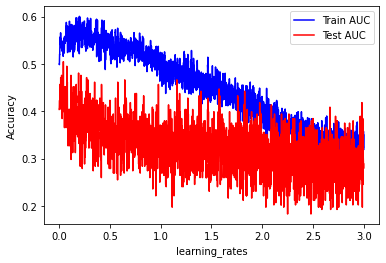

In [59]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  
line1 = ax.plot(learning_rates, train_results, "b", label="Train AUC")
line2 = ax.plot(learning_rates, test_results, "r", label="Test AUC")
plt.ylabel("Accuracy")
plt.xlabel("learning_rates")
plt.legend()
plt.show()

fig.savefig("03.05.AdaBoost.learning_rates.png", bbox_inches="tight")

In [26]:
start = time.time()
kfold = StratifiedKFold(n_splits=12, random_state=PARAM_RANDOM_STATE, shuffle=True)

parameters = {
    "n_estimators": range(10, 2000, 25),
    "learning_rate": np.arange(0.001, 3, 0.01),
}
clf = RandomizedSearchCV(
    AdaBoostClassifier(
        DecisionTreeClassifier(
            class_weight="balanced", max_features="auto", max_depth=3
        ),
    ),
    parameters,
    n_jobs=12,
    scoring=scorer_f1,
    cv=logo,
    n_iter=600,
    verbose=10,
    random_state=PARAM_RANDOM_STATE,
)
clf.fit(X_train, y_train, group_train)

end = time.time()

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass groups=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [27]:
print(f"Tiempo: { round(end - start, 2) } segundos")

Tiempo: 11711.02 segundos


In [28]:
ab = clf.best_estimator_

In [29]:
print(clf.best_score_, clf.best_params_)

0.4404324127128558 {'n_estimators': 1335, 'learning_rate': 1.6709999999999996}


In [30]:
ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': 'balanced',
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 3,
 'base_estimator__max_features': 'auto',
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                        max_features='auto'),
 'learning_rate': 1.6709999999999996,
 'n_estimators': 1335,
 'random_state': None}

In [31]:
print("F1-score training : {:.3f}".format(ab.score(X_train, y_train)))
print("F1-score test: {:.3f}".format(ab.score(X_val, y_val)))


F1-score training : 0.778
F1-score test: 0.481


In [32]:
now = datetime.datetime.now()

pickle.dump(ab, open("03.05.AdaBoost_clf.pkl", "wb"))
pickle.dump(ab, open("03.05.AdaBoost.pkl", "wb"))

clf_results = pd.DataFrame(clf.cv_results_)

clf_results.to_csv("03.05.AdaBoost.csv")
clf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,44.431385,2.061543,1.146813,0.259969,1785,0.381,"{'n_estimators': 1785, 'learning_rate': 0.3809...",0.493628,0.380755,0.374655,0.546428,0.276307,0.289124,0.478960,0.416634,0.349459,0.357081,0.396303,0.083418,320
1,19.460685,1.690488,0.740260,0.165420,985,2.331,"{'n_estimators': 985, 'learning_rate': 2.33099...",0.406675,0.422683,0.459389,0.468765,0.265025,0.355503,0.483912,0.403640,0.324839,0.359402,0.394983,0.065661,335
2,18.248301,1.054199,0.502950,0.137690,810,2.181,"{'n_estimators': 810, 'learning_rate': 2.18099...",0.429923,0.406402,0.410225,0.507820,0.263384,0.357998,0.389549,0.424393,0.291469,0.379543,0.386071,0.066374,403
3,7.125084,1.366387,0.230510,0.079748,285,2.681,"{'n_estimators': 285, 'learning_rate': 2.68099...",0.409673,0.381255,0.395872,0.384656,0.258771,0.306756,0.380015,0.363260,0.245186,0.338609,0.346405,0.054863,552
4,0.247835,0.054464,0.013538,0.005742,10,2.601,"{'n_estimators': 10, 'learning_rate': 2.600999...",0.201755,0.227733,0.255470,0.170214,0.230159,0.222070,0.204849,0.211264,0.199710,0.240545,0.216377,0.022903,597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,37.806311,2.236168,1.151791,0.176055,1610,1.401,"{'n_estimators': 1610, 'learning_rate': 1.4009...",0.448307,0.427966,0.378791,0.519161,0.265699,0.408388,0.468378,0.371655,0.323085,0.421755,0.403318,0.069015,227
596,14.967874,1.198535,0.434849,0.091339,710,2.291,"{'n_estimators': 710, 'learning_rate': 2.29099...",0.405966,0.395133,0.426623,0.498480,0.304860,0.406756,0.417340,0.432669,0.302316,0.399460,0.398960,0.055193,282
597,5.675267,0.622420,0.166645,0.047767,235,2.201,"{'n_estimators': 235, 'learning_rate': 2.20099...",0.382426,0.344791,0.374610,0.401498,0.260627,0.317031,0.389850,0.378820,0.313626,0.351130,0.351441,0.041392,544
598,19.889805,1.629623,0.625342,0.159698,860,1.841,"{'n_estimators': 860, 'learning_rate': 1.84099...",0.404543,0.411993,0.437774,0.502270,0.256717,0.361824,0.442279,0.453579,0.319516,0.396752,0.398725,0.067207,285


In [33]:
# matriz de confusión y classification_report
y_pred_test = ab.predict(X_val)
confusion_matrix(y_val, y_pred_test)

array([[ 9,  0,  1,  6,  0,  0,  0,  0],
       [ 1, 19,  1, 10,  0,  0,  1,  0],
       [ 0,  0, 20,  7,  1,  3,  1,  0],
       [ 3,  4,  4, 16,  4,  1,  0,  0],
       [ 0,  0, 10,  2, 14,  4,  2,  0],
       [ 0,  1,  9,  8,  5,  8,  1,  0],
       [ 0,  0,  4,  1,  9,  2,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  1, 14]])

Text(33.0, 0.5, 'True')

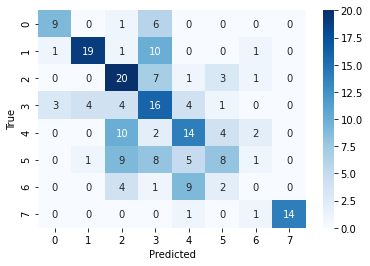

In [34]:
# heat map
cm = confusion_matrix(y_val, y_pred_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")